In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from collections import defaultdict
from io import StringIO
from scipy.optimize import curve_fit

from neural import predict_future

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot

## How much human food resources are available for European countries?

To answer this important question, we will need to import data from the **FAO Dataset**. More specifically, we will focus on the section **Food Balance Sheet** with respect to European countries only. 

In [3]:
FAO_food_balance = pd.read_csv("data/FoodBalanceSheets_E_Europe_1.csv",encoding='latin-1', low_memory=False);

Similar to our previous analysis, we will **remove** all the columns with title **"Y----F"**.

In [4]:
col_to_drop = FAO_food_balance.columns[FAO_food_balance.columns.str.endswith("F")]; #creating a list of columns to be removed
FAO_food_balance = FAO_food_balance.drop(columns=col_to_drop);
FAO_food_balance.columns=FAO_food_balance.columns.str.replace("Y","") #rename the columns by deleting "Y" at the beginning

Secondly, we replace all the **NAN** values with **0** as Item was not available.

In [5]:
FAO_food_balance = FAO_food_balance.fillna(0);

The third step to complete **the cleaning** of FAO_food_balance consists into adapt names of countries in order to have consistency along our different dataframes. During the period that we're analysing, a lot of countries changed names. These changes took place in the aftermath of World War II and the Cold War.

The easiest of these changes that we observe in our dataframe is **The former Yugoslav Republic of Macedonia** should become **North Macedonia**.

In [6]:
FAO_food_balance['Area'] = FAO_food_balance['Area'].replace("The former Yugoslav Republic of Macedonia", "North Macedonia");

Our Dataframe looks like this:

In [7]:
FAO_food_balance.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,1961,1962,1963,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
0,3,Albania,2501,Population,511,Total Population - Both sexes,1000 persons,1669.0,1719.0,1771.0,...,3216.0,3196.0,3180.0,3166.0,3157.0,3151.0,3150.0,3154.0,3162.0,3173.0
1,3,Albania,2511,Wheat and products,5511,Production,1000 tonnes,98.0,146.0,62.0,...,253.0,260.0,231.0,250.0,335.0,333.0,295.0,293.0,300.0,294.0
2,3,Albania,2511,Wheat and products,5611,Import Quantity,1000 tonnes,182.0,89.0,110.0,...,465.0,417.0,414.0,406.0,355.0,343.0,362.0,389.0,377.0,360.0
3,3,Albania,2511,Wheat and products,5072,Stock Variation,1000 tonnes,-52.0,-4.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,Albania,2511,Wheat and products,5911,Export Quantity,1000 tonnes,0.0,0.0,0.0,...,2.0,0.0,0.0,2.0,0.0,0.0,0.0,4.0,4.0,4.0


Given the European countries analysis, and since the structure of this dataset is equivalent to that one, we can again obtain the pairs **(Item Code, 2901) and (Element Code, 664)** for our Europe analysis.

In [8]:
FAO_food_supply = FAO_food_balance[(FAO_food_balance["Item Code"] == 2901) & (FAO_food_balance["Element Code"] == 664)];
FAO_food_supply = FAO_food_supply.drop(columns=["Area Code","Item Code","Item","Element Code","Element", "Unit"])

We can now group by **Area** and see the supplies derived from each item available in countries for that particular year.

In [9]:
FAO_food_supply = FAO_food_supply.set_index("Area")
FAO_food_supply.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
Area,,,,,,,,,,,,,,,,,,,,,
Albania,2223.0,2242.0,2156.0,2270.0,2254.0,2254.0,2262.0,2343.0,2404.0,2415.0,...,2792.0,2874.0,2855.0,2860.0,2947.0,2993.0,3076.0,3132.0,3184.0,3193.0
Austria,3191.0,3193.0,3248.0,3270.0,3220.0,3232.0,3194.0,3221.0,3153.0,3217.0,...,3606.0,3640.0,3719.0,3737.0,3717.0,3723.0,3724.0,3735.0,3739.0,3768.0
Belarus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2901.0,2987.0,3084.0,3186.0,3200.0,3126.0,3196.0,3400.0,3400.0,3250.0
Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3722.0,3716.0,3716.0,3713.0,3702.0,3697.0,3707.0,3720.0,3715.0,3733.0
Belgium-Luxembourg,2923.0,2908.0,3007.0,3061.0,2966.0,3067.0,3088.0,3032.0,3156.0,3068.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In order to check for anomalies in our data, we would like to analyze the **timeline**. We therefore transpose the dataframe and plot the timeline of how food supply in different countries evolved. Legend was suppressed as it is too large.

In [10]:
FAO_food_supply = FAO_food_supply.transpose();

In [11]:
#converting the year from string to int
FAO_food_supply.index = FAO_food_supply.index.astype(int)

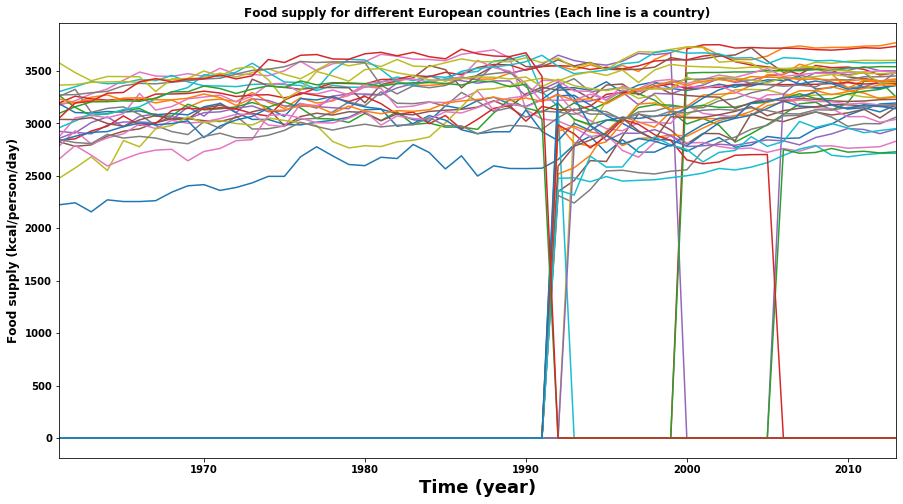

In [12]:
FAO_food_supply.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply (kcal/person/day)", fontsize=12)
plt.title("Food supply for different European countries (Each line is a country)");

We can observe a similar situation in this graph as we did in the African countries analysis. As such, we can assume that some countries may have changed names or maybe some other situations occured, which caused countries data to stop being recorded/collected. 

Let's then see which countries have zeros in the values for food supplies.

In [13]:
FAO_food_supply.columns.values[(FAO_food_supply == 0).any()]

array(['Belarus', 'Belgium', 'Belgium-Luxembourg',
       'Bosnia and Herzegovina', 'Croatia', 'Czechia', 'Czechoslovakia',
       'Estonia', 'Latvia', 'Lithuania', 'Luxembourg', 'Montenegro',
       'Republic of Moldova', 'Russian Federation', 'Serbia',
       'Serbia and Montenegro', 'Slovakia', 'Slovenia', 'North Macedonia',
       'Ukraine', 'USSR', 'Yugoslav SFR'], dtype=object)

Respecting the cronology, we observe that in 1991-1992 there were some countries on which data started to get collected, as well as others from which data disappeared. After some search online on these countries, we actually find out that:
- **USSR** (Union of Soviet Socialist Republics) was a union of a lot of countries, some of which were not even located in Europe. The Union was dissolved in 26 December 1991, and so the countries **Belarus**, **Ukraine**, **Estonia**, **Republic of Moldova**, **Russian Federation**, **Latvia**, **Lithuania** are the europeans countries that became independent in Europe.
- **Yugoslav SFR** was made up of the countries that became **Bosnia and Herzegovina**, **Croatia**, **Serbia and Montenegro**, **North Macedonia**, **Slovenia**, all of which attained their independence between 25 June 1991 - 27 April 1992
- **Czechoslovakia** was dissoluted in 1 January 1993, after a period called The Velvet Revolution (because of the peaceful ways), and became the two countries **Czechia** and **Slovakia**
- **Serbia and Montenegro** separated themselves in 2006, breaking up the last union still recognized as a sucessor of Yougoslavia
- **Belgium-Luxembourg** (2003) does not have a main reason to exist, as there is no major event happening in 2003 that would justify the mixing of the two countries. Our understanding lead us to believe this was probably just a grouping created in FAO when collecting the data from the two countries.

Let's then take care of all these cases

In [14]:
FAO_food_supply_cleared = FAO_food_supply.copy()

FAO_food_supply_cleared['Belarus'] += FAO_food_supply_cleared['USSR']
FAO_food_supply_cleared['Ukraine'] += FAO_food_supply_cleared['USSR']
FAO_food_supply_cleared['Estonia'] += FAO_food_supply_cleared['USSR']
FAO_food_supply_cleared['Republic of Moldova'] += FAO_food_supply_cleared['USSR']
FAO_food_supply_cleared['Russian Federation'] += FAO_food_supply_cleared['USSR']
FAO_food_supply_cleared['Latvia'] += FAO_food_supply_cleared['USSR']
FAO_food_supply_cleared['Lithuania'] += FAO_food_supply_cleared['USSR']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('USSR', 1)

FAO_food_supply_cleared['Bosnia and Herzegovina'] += FAO_food_supply_cleared['Yugoslav SFR']
FAO_food_supply_cleared['Croatia'] += FAO_food_supply_cleared['Yugoslav SFR']
FAO_food_supply_cleared['Serbia and Montenegro'] += FAO_food_supply_cleared['Yugoslav SFR']
FAO_food_supply_cleared['North Macedonia'] += FAO_food_supply_cleared['Yugoslav SFR']
FAO_food_supply_cleared['Slovenia'] += FAO_food_supply_cleared['Yugoslav SFR']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Yugoslav SFR', 1)

FAO_food_supply_cleared['Czechia'] += FAO_food_supply_cleared['Czechoslovakia']
FAO_food_supply_cleared['Slovakia'] += FAO_food_supply_cleared['Czechoslovakia']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Czechoslovakia', 1)

FAO_food_supply_cleared['Serbia'] += FAO_food_supply_cleared['Serbia and Montenegro']
FAO_food_supply_cleared['Montenegro'] += FAO_food_supply_cleared['Serbia and Montenegro']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Serbia and Montenegro', 1)

FAO_food_supply_cleared['Luxembourg'] += FAO_food_supply_cleared['Belgium-Luxembourg']
FAO_food_supply_cleared['Belgium'] += FAO_food_supply_cleared['Belgium-Luxembourg']
FAO_food_supply_cleared = FAO_food_supply_cleared.drop('Belgium-Luxembourg', 1)

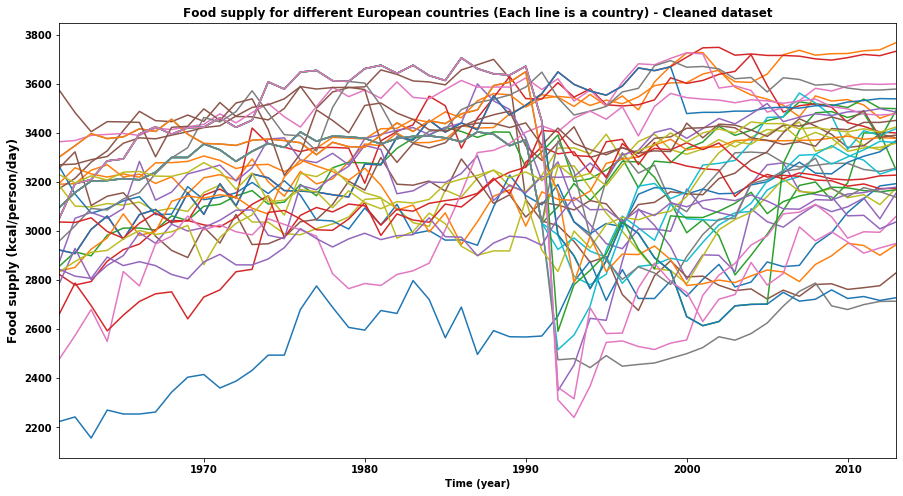

In [15]:
FAO_food_supply_cleared.plot.line(legend = False)
plt.xlabel("Time (year)")
plt.ylabel("Food supply (kcal/person/day)", fontsize=12)
plt.title("Food supply for different European countries (Each line is a country) - Cleaned dataset");

We observe a drop in the *food supply* from most countries that came from the former USSR, which we find to be interesting. While it might not be the case for all of these countries, some of them are vey poor and as such, when separated from the world power that was the USSR, their ability to provide and produce for themselves may have dropped significantly, which is coherent with what we observe. As such, we continue our analysis with these values.

Next, we want to add more columns representing future years until 2020 to prepare cells for extrapolation to make predictions about possible scenarios.

In [16]:
# Adding columns for the new years
from helpfunc import prepare_future
FAO_food_supply_cleared = prepare_future(FAO_food_supply_cleared, 2014, 2020)

In [23]:
FAO_food_supply_cleared = predict_future(FAO_food_supply_cleared, "europe_rnn.pkl")

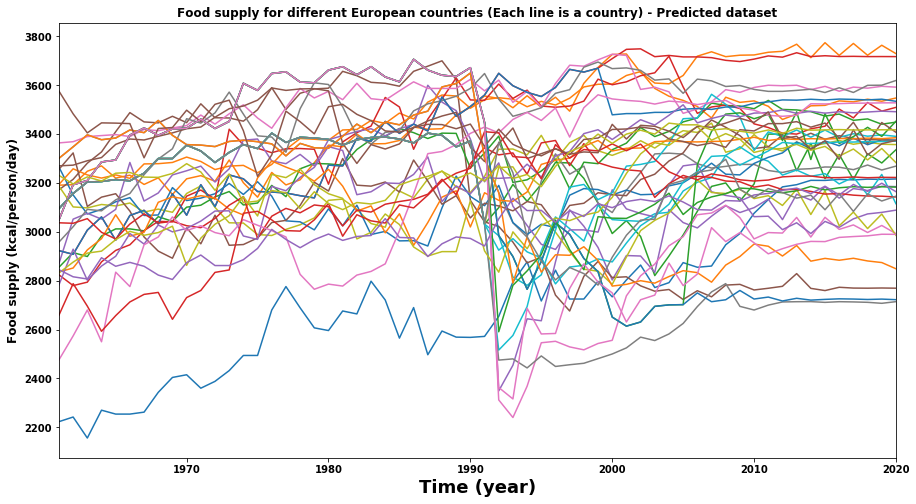

In [24]:
FAO_food_supply_cleared.plot.line(legend = False)
plt.xlabel("Time (year)", fontsize=18)
plt.ylabel("Food supply (kcal/person/day)", fontsize=12)
plt.title("Food supply for different European countries (Each line is a country) - Predicted dataset");

# What is the ideal amount of kcal each European country needs?
Once again, we do a very similar analysis on European countries as we did for the African ones.

### 1- What is the kcal demand of a regular person in order to be healthy? (REMOVE; UNNECESSARY; SINCE IS ONLY RECALCULATIONS)
We load the calories demand datasets we scraped for the webpage [Calories](https://health.gov/dietaryguidelines/2015/guidelines/appendix-2/), datasets will we working on to match with population data

In [24]:
male_calory_demand = pd.read_excel("data/calories_demand.xlsx",header =None, sheet_name=0, names=['age', 'sedentary', 'moderate', 'active'])

In [25]:
females_calory_demand =  pd.read_excel("data/calories_demand.xlsx",header =None, sheet_name=1, names=['age', 'sedentary', 'moderate', 'active'])

In order to better work with the information we have collected, we will make some simplifications on the data. Mainly, we will:
- in the calories demands database, take the **active lifestyle** column. According to [World Health Organization](https://www.afro.who.int/health-topics/physical-activity), regular physical activity helps to maintain a healthy body and reduces the risk of disease. For this reason, we want African people to be able to embrace an active lifestyle and therefore we assume an higher amount of kCal needed
- group the ages into ranges that match the ranges provided in the World Population Database

In [26]:
male_calories_act = male_calory_demand.drop(columns=['sedentary', 'moderate'])
females_calories_act = females_calory_demand.drop(columns=['sedentary', 'moderate'])
male_calories_act.rename(columns={'active':'input kcal'}, inplace=True)
females_calories_act.rename(columns={'active':'input kcal'}, inplace=True)

We have now obtained a caloric demand for simpler calculations in the future and stored in the two precedent datasets.  
Now, we need a  way to match the age groups in this dataframe, to the ones in the population database we obtained. As such, let's analyse how ages are represented in our calory demand dataframes.

In [27]:
male_calories_act['age'].unique()

array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       '19-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50',
       '51-55', '56-60', '61-65', '66-70', '71-75', '76 and up', nan],
      dtype=object)

We can see there are ranges of ages with different sizes (which makes sense, because different age groups have different caloric needs). We'll present a function that creates one row per individual age

In [28]:
def single_age(age_range):
    if type(age_range) ==  float: # nans are the only floats in the age column
        return -1
    elif type(age_range) == int:
        return age_range
    elif re.search('\d-\d', age_range):
        group = age_range.split('-')
        return list(range(int(group[0]), int(group[1])+1))
    elif age_range == "76 and up":
        return list(range(76, 101+1))

In [29]:
def explode_age(data_frame):
    accum = []
    for i in data_frame.index:
        row = data_frame.loc[i]
        single = single_age(row['age'])
        if single == -1: # we ignore the nan values, as their rows are empty
            continue
        if type(single) == int:
            accum.append((single, row['input kcal']))
        elif type(single) == list:
            accum.extend([(x, row['input kcal']) for x in single]) 
    return pd.DataFrame(accum, columns=data_frame.columns)

We apply the function to our two dataframe:

In [30]:
male_explode = explode_age(male_calories_act)
female_explode = explode_age(females_calories_act)

In [31]:
male_explode['age'].unique()

array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101], dtype=int64)

Ages are now unique in each dataframe ( `male_explode` and `female_explode` ) and there's a caloric input value for each of them.

The last step to allow the match with the population database is to build the **same age groups** we have in that set.  
We do this in the next two functions:

In [32]:
def group(age):
    i = int(5*(age//5))
    return "{}-{}".format(i, i+4)

In [33]:
def compress_ages(data_frame):
    accum = defaultdict(list)
    for i in data_frame.index:
        row = data_frame.loc[i]
        g_id = group(row['age'])
        if g_id == "100-104":
            g_id = "100+"
        accum[g_id].append(row['input kcal'])
    for i in accum:
        accum[i] = sum(accum[i]) / len(accum[i])
    return pd.DataFrame.from_dict(accum, orient='index')

We can lastly apply the functions to the dataframes:

In [34]:
new_male_need = compress_ages(male_explode)
new_female_need = compress_ages(female_explode)

We also use the age group as new index and rename the columns:

In [35]:
new_male_need.index.name = 'age_group'
new_male_need = new_male_need.rename(columns={0: 'input kcal'})
new_female_need.index.name = 'age_group'
new_female_need = new_female_need.rename(columns={0: 'input kcal'})

Let's see the result we have achieved and collected in our matchable dataframe `new_male_need` and `new_female_need`. The unit here is **kcal/persona/day**.

In [36]:
new_male_need.head()

,input kcal
age_group,
0-4,1333.333333
5-9,1840.000000
10-14,2440.000000
15-19,3120.000000
20-24,3000.000000


### 2- How many people live in Europe?

In this second part of our analysis, we load the list of **European countries**. Secondly, we load the **World Population Database** (United Nation) and therefore we obtain two dataframes: one for males and the other one for females.

In [37]:
with open ("data/european_countries.txt",'r') as eu_c:
    eu_countries = [line.rstrip() for line in eu_c] #loading list

FileNotFoundError: [Errno 2] No such file or directory: 'data/european_countries.txt'

We need to check if the FAO Database contains data regarding **every country** in Europe. We will check the instection with the list **eu_countries**.

In [38]:
eu_to_remove = list(set(eu_countries) - set(FAO_food_supply_cleared.columns.values))
print("List of countries for which no data is available: " + str(eu_to_remove))

NameError: name 'eu_countries' is not defined

Because there are less countries in Europe, and also because most European countries are part of ONU, we expected most countries to be present in both the FAO database and the population database. These **Channel Islands** are a small set of islands in the English Channel, and because they are so small, we can safely remove them from our scope of interest.

In [39]:
eu_countries = [i for i in eu_countries if not i in eu_to_remove]
eu_to_remove = list(set(eu_countries) - set(FAO_food_supply_cleared.columns.values))
print("List of countries for which no data is available: " + str(eu_to_remove))

NameError: name 'eu_countries' is not defined

**World Population Database** (United Nation) is now loaded and cleaned. This preprocessing is necessary in order to sort things out for next more complex steps.  
**A note**: Since the population data are per 1000 people, we decide to multiply for the same factor (1000) and get back to the real number.

In [38]:
#loading datasets
pop_male = pd.read_excel("data/POPULATION_BY_AGE_MALE.xlsx", sheet_name="ESTIMATES")
pop_female = pd.read_excel("data/POPULATION_BY_AGE_FEMALE.xlsx", sheet_name="ESTIMATES")

In [39]:
#cleaning male population dataset
pop_male.drop(columns=["Index", "Variant", "Notes", "Country code", "Type", "Parent code"], inplace=True)
pop_male.rename(columns={"Reference date (as of 1 July)": "year", "Region, subregion, country or area *": "country"}, inplace=True)
#taking only european countries
pop_male = pop_male[pop_male['country'].isin(eu_countries)]

#cleaning female dataset
pop_female.drop(columns=["Index", "Variant", "Notes", "Country code", "Type", "Parent code"], inplace=True)
pop_female.rename(columns={"Reference date (as of 1 July)": "year", "Region, subregion, country or area *": "country"}, inplace=True)
#only european
pop_female = pop_female[pop_female['country'].isin(eu_countries)]

In [40]:
#take in consideration the 1000 of population from the beginning now
pop_male.iloc[:, 2:] = pop_male.iloc[:, 2:]*1000
pop_female.iloc[:, 2:] = pop_female.iloc[:, 2:]*1000

Let's have a look at the final version of male population data grouped by age:

In [41]:
pop_male.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
3135,Belarus,1950,333700,282651,395174,382562,361905,237761,150660,206475,...,138445,124045,99216,68726,41415,19537,7648,2113,365,35
3136,Belarus,1955,418684,315056,264730,374177,357223,337374,219617,136496,...,128674,111772,95381,70127,42393,19507,8196,2262,415,47
3137,Belarus,1960,491730,406036,305601,255607,360905,342271,323037,208441,...,150864,108601,89962,70827,45805,21818,8211,2371,420,50
3138,Belarus,1965,448162,482745,398975,299589,248620,350831,331524,311625,...,158297,130151,89304,68499,47682,24484,9262,2393,448,52
3139,Belarus,1970,368381,450207,485335,400660,299407,247750,348188,327625,...,147426,140703,110454,70311,47732,27537,10041,2554,418,51


In this context, the population dataframe for males **pop_male** and for females **pop_female** contains measurement of population for years from 1950 to 2020 with a frequency of **5 years**, we now decide to interpolate in order to obtain values for intermediate years. 

First of all, we want to look at the data in order to undestand what is the population growth's **trend**  over the years.  
In this context, we choose to consider just some of the columns from the two dataset as example of the trends. Specifically, we are focusing on the same range **10-39 years**, to get an interesting comparison on the demographics evolotion between European and African countries.

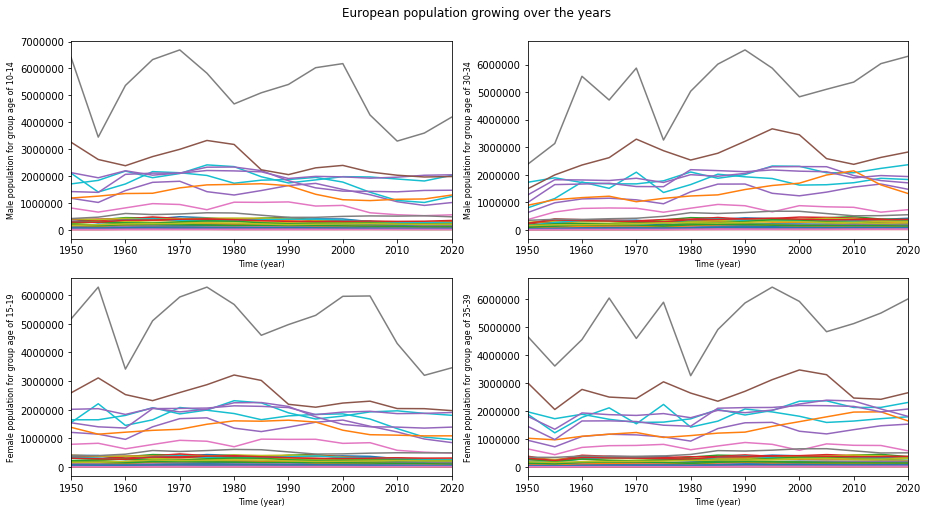

In [44]:
fig, axs = plt.subplots(2, 2)
x = pop_male.year.drop_duplicates()
for country in pop_male.country.drop_duplicates():
    y = pop_male[(pop_male.country==country)]["10-14"]    
    axs[0, 0].plot(x,y)
axs[0, 0].set_xlabel("Time (year)",fontsize=8)
axs[0, 0].set_ylabel("Male population for group age of 10-14", fontsize=8);
axs[0, 0].set_xlim(1950,2020)


for country in pop_male.country.drop_duplicates():
    y = pop_male[(pop_male.country==country)]["30-34"]
    axs[0, 1].plot(x,y)
axs[0, 1].set_xlabel("Time (year)",fontsize=8)
axs[0, 1].set_ylabel("Male population for group age of 30-34", fontsize=8);
axs[0, 1].set_xlim(1950,2020)

x = pop_female.year.drop_duplicates()
for country in pop_female.country.drop_duplicates():
    y = pop_female[(pop_female.country==country)]["15-19"]
    axs[1, 0].plot(x,y)
axs[1, 0].set_xlabel("Time (year)",fontsize=8)
axs[1, 0].set_ylabel("Female population for group age of 15-19", fontsize=8);
axs[1, 0].set_xlim(1950,2020)


for country in pop_female.country.drop_duplicates():
    y = pop_female[(pop_female.country==country)]["35-39"]
    axs[1, 1].plot(x,y)
axs[1, 1].set_xlabel("Time (year)",fontsize=8)
axs[1, 1].set_ylabel("Female population for group age of 35-39", fontsize=8);
axs[1, 1].set_xlim(1950,2020)


fig.suptitle("European population growing over the years", y=0.94);

Unlike Africa, we don't observe a steady increase in the population over the years. It is known that because Europe is a more developed zone in the world, and according to regular census, the amount of people being born has been cyclic. It may be interesting to point out that the amount of teenager (**10-19 years old**) population in these countries seems to have some kind of inverse relationship with the amount of working class people in an age that is considered to nowadays be an age suitable to have children. This further confirms that when the ammount of children is at its minimum in these cycles, then people start having more and more kids again.

We now do a similar interpolation on the data, in order to obtain a *growth of the population per year*, instead of the previous *5 years* periods.

## This code needs to be commented

In [45]:
coll = ['country', 'year'] 

pop_temp_m= pd.DataFrame(columns = coll )
pop_male_yearly= pd.DataFrame(columns = coll )
for country in pop_male.country.drop_duplicates():
    for ages in pop_male.columns[2:]:
        x = pop_male.year.drop_duplicates()
        y = pop_male[(pop_male.country==country)][ages].astype(float)
        xnew = np.arange(1950,2021)
        ynew = np.interp(xnew, x, y, left=None, right=None, period=None)
        pop_temp_m[ages] = ynew
        pop_temp_m["country"]=country
        pop_temp_m["year"]=xnew  
    pop_male_yearly = pop_male_yearly.append(pop_temp_m, sort=False)
pop_male_yearly = pop_male_yearly.reset_index().drop(columns="index")

    
pop_temp_f= pd.DataFrame(columns = coll )
pop_female_yearly= pd.DataFrame(columns = coll )
for country in pop_female.country.drop_duplicates():
    for ages in pop_female.columns[2:]:
        x = pop_female.year.drop_duplicates()
        y = pop_female[(pop_female.country==country)][ages].astype(float)
        xnew = np.arange(1950,2021)
        ynew = np.interp(xnew, x, y, left=None, right=None, period=None)
        pop_temp_f[ages] = ynew
        pop_temp_f["country"]=country
        pop_temp_f["year"]=xnew  
    pop_female_yearly = pop_female_yearly.append(pop_temp_f, sort=False)
pop_female_yearly = pop_female_yearly.reset_index().drop(columns="index")

Let's see how the new dataframes for males and females population look like:

In [46]:
pop_male_yearly.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,333700.0,282651.0,395174.0,382562.0,361905.0,237761.0,150660.0,206475.0,...,138445.0,124045.0,99216.0,68726.0,41415.0,19537.0,7648.0,2113.0,365.0,35.0
1,Belarus,1951,350696.8,289132.0,369085.2,380885.0,360968.6,257683.6,164451.4,192479.2,...,136490.8,121590.4,98449.0,69006.2,41610.6,19531.0,7757.6,2142.8,375.0,37.4
2,Belarus,1952,367693.6,295613.0,342996.4,379208.0,360032.2,277606.2,178242.8,178483.4,...,134536.6,119135.8,97682.0,69286.4,41806.2,19525.0,7867.2,2172.6,385.0,39.8
3,Belarus,1953,384690.4,302094.0,316907.6,377531.0,359095.8,297528.8,192034.2,164487.6,...,132582.4,116681.2,96915.0,69566.6,42001.8,19519.0,7976.8,2202.4,395.0,42.2
4,Belarus,1954,401687.2,308575.0,290818.8,375854.0,358159.4,317451.4,205825.6,150491.8,...,130628.2,114226.6,96148.0,69846.8,42197.4,19513.0,8086.4,2232.2,405.0,44.6


In [47]:
pop_female_yearly.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,325456.0,287716.0,420006.0,403120.0,424672.0,338168.0,223359.0,326549.0,...,178569.0,183039.0,152746.0,119379.0,85709.0,39512.0,20284.0,7706.0,1924.0,293.0
1,Belarus,1951,338789.2,291637.0,389910.6,402225.4,415571.6,350871.6,242416.2,302527.8,...,179256.4,177849.8,153480.6,119761.2,85312.8,41588.0,19740.8,7352.0,1810.6,277.8
2,Belarus,1952,352122.4,295558.0,359815.2,401330.8,406471.2,363575.2,261473.4,278506.6,...,179943.8,172660.6,154215.2,120143.4,84916.6,43664.0,19197.6,6998.0,1697.2,262.6
3,Belarus,1953,365455.6,299479.0,329719.8,400436.2,397370.8,376278.8,280530.6,254485.4,...,180631.2,167471.4,154949.8,120525.6,84520.4,45740.0,18654.4,6644.0,1583.8,247.4
4,Belarus,1954,378788.8,303400.0,299624.4,399541.6,388270.4,388982.4,299587.8,230464.2,...,181318.6,162282.2,155684.4,120907.8,84124.2,47816.0,18111.2,6290.0,1470.4,232.2


Lastly, we will compute the total population per year. This new dataframe **pop_tot** will be useful for the next section of our analysis.

In [48]:
pop_tot = pop_male_yearly.copy()
pop_tot.iloc[:, 2:] = pop_male_yearly.iloc[:, 2:] + pop_female_yearly.iloc[:, 2:]
sum_ind = pop_tot.columns[2:]
pop_tot['Population'] = pop_tot[sum_ind].sum(axis=1)
pop_tot.drop(columns=sum_ind, inplace=True)

For the next analysis we will need to match this data with the `FAO_food_Balance`. We proceed to give to our population data the same shape as the other dataset

In [49]:
#We sort values by year, we group them by country and we tranpose the values in columns Population.
#In the function lambda we reset the index. The unstack() allows to return a new dataframe with 
#a new level of columns.

years = list(pop_tot.year.drop_duplicates().sort_values())
pop_tot = pop_tot.sort_values('year').groupby("country")['Population'].apply(lambda df: df.reset_index(drop=True)).unstack()
pop_tot.columns = years
pop_tot.index.name = 'Country'

In [50]:
pop_tot.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Albania,1263164.0,1294529.4,1325894.8,1357260.2,1388625.6,1419991.0,1463211.0,1506431.0,1549651.0,1592871.0,...,2936528.0,2925027.0,2913526.0,2902025.0,2890524.0,2887979.2,2885434.4,2882889.6,2880344.8,2877800.0
Austria,6936442.0,6939834.4,6943226.8,6946619.2,6950011.6,6953404.0,6976877.8,7000351.6,7023825.4,7047299.2,...,8463689.4,8517433.8,8571178.2,8624922.6,8678667.0,8744213.6,8809760.2,8875306.8,8940853.4,9006400.0
Belarus,7745004.0,7745446.2,7745888.4,7746330.6,7746772.8,7747215.0,7822748.2,7898281.4,7973814.6,8049347.8,...,9424345.6,9428115.2,9431884.8,9435654.4,9439424.0,9441403.4,9443382.8,9445362.2,9447341.6,9449321.0
Belgium,8637521.0,8687471.8,8737422.6,8787373.4,8837324.2,8887275.0,8943292.2,8999309.4,9055326.6,9111343.8,...,11008574.2,11078413.4,11148252.6,11218091.8,11287931.0,11348268.0,11408605.0,11468942.0,11529279.0,11589616.0
Bosnia and Herzegovina,2661296.0,2716296.8,2771297.6,2826298.4,2881299.2,2936300.0,2994172.8,3052045.6,3109918.4,3167791.2,...,3650254.8,3595031.6,3539808.4,3484585.2,3429362.0,3399652.6,3369943.2,3340233.8,3310524.4,3280815.0


### 3- Estimantion of ideal human food demand in Europe 

Now we multiply each column of the population data for each matching `age_group` in the calories table (that here we squeeze to allow the multiplication, similar to a transpose rows/columns of the dataset).  
We obtain two datasets: `total_cal_male` and `total_cal_female` reporting total calories needed for **each country in each year per age group per gender**. 
The unit here is **kcal/day**.

In [51]:
#total calories male
pop_mal_mult = pop_male_yearly.drop(columns=["country", "year"])
total_cal_male = pop_mal_mult.multiply(new_male_need.squeeze()) # squeeze adapts the dimension of the dataframe
total_cal_male.insert(0,"country",pop_male_yearly.country)
total_cal_male.insert(1,"year",pop_male_yearly.year)
total_cal_male.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,4.449333e+08,520077840.0,964224560.0,1.193593e+09,1.085715e+09,713283000.0,451980000.0,586389000.0,...,365494800.0,322517000.0,257961600.0,178687600.0,101052600.0,46888800.0,18355200.0,5071200.0,876000.0,84000.0
1,Belarus,1951,4.675957e+08,532002880.0,900567888.0,1.188361e+09,1.082906e+09,773050800.0,493354200.0,546640928.0,...,360335712.0,316135040.0,255967400.0,179416120.0,101529864.0,46874400.0,18618240.0,5142720.0,900000.0,89760.0
2,Belarus,1952,4.902581e+08,543927920.0,836911216.0,1.183129e+09,1.080097e+09,832818600.0,534728400.0,506892856.0,...,355176624.0,309753080.0,253973200.0,180144640.0,102007128.0,46860000.0,18881280.0,5214240.0,924000.0,95520.0
3,Belarus,1953,5.129205e+08,555852960.0,773254544.0,1.177897e+09,1.077287e+09,892586400.0,576102600.0,467144784.0,...,350017536.0,303371120.0,251979000.0,180873160.0,102484392.0,46845600.0,19144320.0,5285760.0,948000.0,101280.0
4,Belarus,1954,5.355829e+08,567778000.0,709597872.0,1.172664e+09,1.074478e+09,952354200.0,617476800.0,427396712.0,...,344858448.0,296989160.0,249984800.0,181601680.0,102961656.0,46831200.0,19407360.0,5357280.0,972000.0,107040.0


In [52]:
#total calories female
pop_fem_mult = pop_female_yearly.drop(columns=["country", "year"])
total_cal_female = pop_fem_mult.multiply(new_female_need.squeeze()) 
total_cal_female.insert(0,"country",pop_male_yearly.country)
total_cal_female.insert(1,"year",pop_male_yearly.year)
total_cal_female.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,4.122443e+08,494871520.0,907212960.0,967488000.0,1.019213e+09,811603200.0,500324160.0,718407800.0,...,392851800.0,373399560.0,305492000.0,238758000.0,171418000.0,79024000.0,40568000.0,15412000.0,3848000.0,586000.0
1,Belarus,1951,4.291330e+08,501615640.0,842206896.0,965340960.0,9.973718e+08,842091840.0,543012288.0,665561160.0,...,394364080.0,362813592.0,306961200.0,239522400.0,170625600.0,83176000.0,39481600.0,14704000.0,3621200.0,555600.0
2,Belarus,1952,4.460217e+08,508359760.0,777200832.0,963193920.0,9.755309e+08,872580480.0,585700416.0,612714520.0,...,395876360.0,352227624.0,308430400.0,240286800.0,169833200.0,87328000.0,38395200.0,13996000.0,3394400.0,525200.0
3,Belarus,1953,4.629104e+08,515103880.0,712194768.0,961046880.0,9.536899e+08,903069120.0,628388544.0,559867880.0,...,397388640.0,341641656.0,309899600.0,241051200.0,169040800.0,91480000.0,37308800.0,13288000.0,3167600.0,494800.0
4,Belarus,1954,4.797991e+08,521848000.0,647188704.0,958899840.0,9.318490e+08,933557760.0,671076672.0,507021240.0,...,398900920.0,331055688.0,311368800.0,241815600.0,168248400.0,95632000.0,36222400.0,12580000.0,2940800.0,464400.0


Once we have the calories needed for both gender, we can add them together easily to achieve total calories needed for **each country in each year per age group**, and we collect them in the dataframe `total_cal_ages`. The unit is still **kcal/day**.

In [53]:
#copy the male inside the total (to mantain country and year columns) and sum with female
total_cal_ages = total_cal_male.copy()
sum_ind = total_cal_ages.columns[2:]
total_cal_ages[sum_ind] = total_cal_ages[sum_ind] + total_cal_female[sum_ind]
total_cal_ages.head()

,country,year,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,...,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90-94,95-99,100+
0,Belarus,1950,8.571776e+08,1.014949e+09,1.871438e+09,2.161081e+09,2.104928e+09,1.524886e+09,9.523042e+08,1.304797e+09,...,758346600.0,695916560.0,563453600.0,417445600.0,272470600.0,125912800.0,58923200.0,20483200.0,4724000.0,670000.0
1,Belarus,1951,8.967287e+08,1.033619e+09,1.742775e+09,2.153702e+09,2.080278e+09,1.615143e+09,1.036366e+09,1.212202e+09,...,754699792.0,678948632.0,562928600.0,418938520.0,272155464.0,130050400.0,58099840.0,19846720.0,4521200.0,645360.0
2,Belarus,1952,9.362798e+08,1.052288e+09,1.614112e+09,2.146323e+09,2.055627e+09,1.705399e+09,1.120429e+09,1.119607e+09,...,751052984.0,661980704.0,562403600.0,420431440.0,271840328.0,134188000.0,57276480.0,19210240.0,4318400.0,620720.0
3,Belarus,1953,9.758310e+08,1.070957e+09,1.485449e+09,2.138944e+09,2.030977e+09,1.795656e+09,1.204491e+09,1.027013e+09,...,747406176.0,645012776.0,561878600.0,421924360.0,271525192.0,138325600.0,56453120.0,18573760.0,4115600.0,596080.0
4,Belarus,1954,1.015382e+09,1.089626e+09,1.356787e+09,2.131564e+09,2.006327e+09,1.885912e+09,1.288553e+09,9.344180e+08,...,743759368.0,628044848.0,561353600.0,423417280.0,271210056.0,142463200.0,55629760.0,17937280.0,3912800.0,571440.0


To find the total calories needed for **each country in each year** we then proceed to the sum over all the age groups, collected in `total_cal`. The unit is still **kcal/day**.

In [54]:
total_cal = total_cal_ages.copy()
sum_ind = total_cal.columns[2:]

#computing sum of cal over ages, removing ages
total_cal['Calories'] = total_cal[sum_ind].sum(axis=1)
total_cal.drop(columns=sum_ind, inplace=True)

Last step of the calculation is top convert the values from **kcal/day** to **kcal/year**. The factor is **365**. In this way, we have obtained overall values of kcal that each country neeeded from 1950 to 2020.

In [55]:
change_col = total_cal_ages.columns[2:] #index for the first 3 dataframes are the same
total_cal_male[change_col] = total_cal_male[change_col]*365
total_cal_female[change_col] = total_cal_male[change_col]*365
total_cal_ages[change_col] = total_cal_male[change_col]*365
total_cal['Calories'] = total_cal['Calories']*365

Let's take a look at total calories dataframe **total_cal**:

In [56]:
total_cal.sort_values(by="Calories").head() #maybe in opposite way?

,country,year,Calories
923,Iceland,1950,1.196099e+11
924,Iceland,1951,1.218949e+11
925,Iceland,1952,1.241799e+11
926,Iceland,1953,1.264648e+11
927,Iceland,1954,1.287498e+11


For the sake of consistency, we will now reshape our dataframe `total_cal` into a new one `total_cal_final` according to the same schema seen for `FAO_food_supply_cleared`.

In [57]:
# Same transformation used before but in this case we transpose over the Calories

total_cal_final = total_cal.copy()
years = list(total_cal_final.year.drop_duplicates().sort_values())
total_cal_final = total_cal_final.sort_values('year').groupby("country")['Calories'].apply(lambda df: df.reset_index(drop=True)).unstack()
total_cal_final.columns = years
total_cal_final.index.name = 'Country'

Drawing a sample of the final shaped dataframe total calories `total_cal`:

In [58]:
total_cal_final.head()

,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Country,,,,,,,,,,,,,,,,,,,,,
Albania,1.041791e+12,1.067157e+12,1.092523e+12,1.117889e+12,1.143255e+12,1.168621e+12,1.202214e+12,1.235807e+12,1.269400e+12,1.302993e+12,...,2.558970e+12,2.551603e+12,2.544237e+12,2.536870e+12,2.529503e+12,2.526050e+12,2.522597e+12,2.519144e+12,2.515691e+12,2.512237e+12
Austria,5.906169e+12,5.912127e+12,5.918085e+12,5.924043e+12,5.930001e+12,5.935959e+12,5.950704e+12,5.965449e+12,5.980194e+12,5.994939e+12,...,7.368272e+12,7.414042e+12,7.459812e+12,7.505582e+12,7.551352e+12,7.603258e+12,7.655163e+12,7.707068e+12,7.758973e+12,7.810878e+12
Belarus,6.581842e+12,6.573869e+12,6.565896e+12,6.557924e+12,6.549951e+12,6.541978e+12,6.585445e+12,6.628913e+12,6.672380e+12,6.715847e+12,...,8.184568e+12,8.171641e+12,8.158714e+12,8.145787e+12,8.132860e+12,8.125860e+12,8.118860e+12,8.111861e+12,8.104861e+12,8.097861e+12
Belgium,7.440138e+12,7.475404e+12,7.510669e+12,7.545935e+12,7.581201e+12,7.616467e+12,7.656335e+12,7.696202e+12,7.736070e+12,7.775938e+12,...,9.508244e+12,9.565091e+12,9.621938e+12,9.678785e+12,9.735632e+12,9.787514e+12,9.839396e+12,9.891278e+12,9.943160e+12,9.995042e+12
Bosnia and Herzegovina,2.207555e+12,2.252332e+12,2.297108e+12,2.341885e+12,2.386662e+12,2.431439e+12,2.479545e+12,2.527652e+12,2.575759e+12,2.623865e+12,...,3.196515e+12,3.144872e+12,3.093230e+12,3.041587e+12,2.989945e+12,2.963127e+12,2.936309e+12,2.909492e+12,2.882674e+12,2.855856e+12


Let's go on with a quick visualization of the data in order to understand the trend over countries

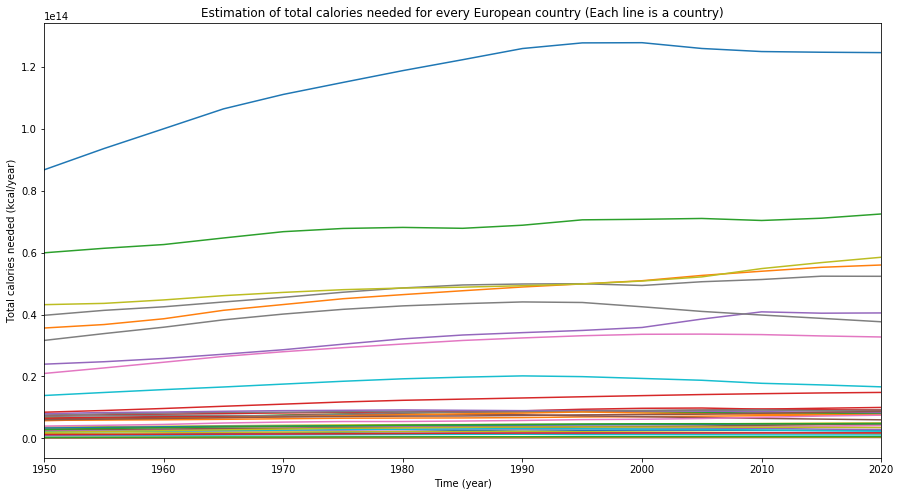

In [67]:
plt.plot(total_cal_final.T);
plt.xlabel('Time (year)')
plt.ylabel("Total calories needed (kcal/year)")
plt.title("Estimation of total calories needed for every European country (Each line is a country)")
plt.xlim(1950, 2020);

From this necessity graph, we obtain that there are countries that have many more people (and thus, more calories needed) than others. We also observe that, even though some age groups have more or less people in specific years, in the end, the overall population of all countries (and their needs) has been growing somewhat steadily. Below we plot this same dataframe, but with a logarithmic y scale, just to get an interesting sense on the data.

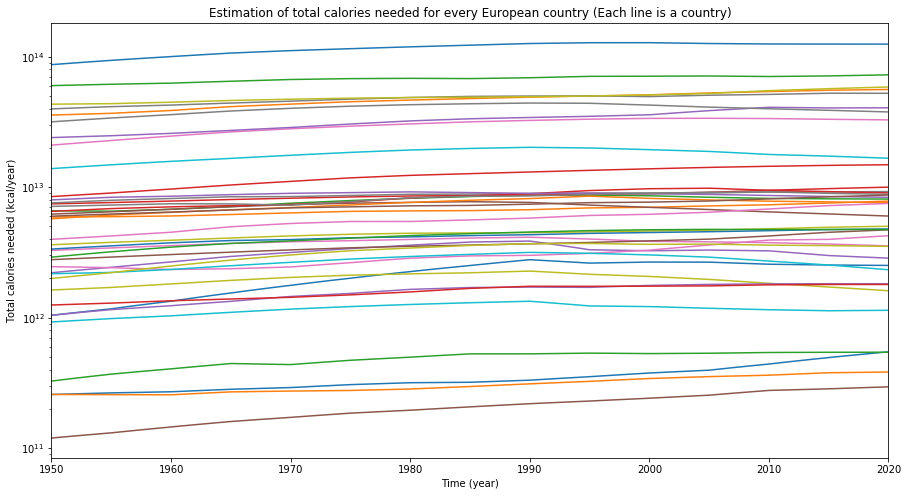

In [68]:
plt.plot(total_cal_final.T);
plt.xlabel('Time (year)')
plt.ylabel("Total calories needed (kcal/year)")
plt.title("Estimation of total calories needed for every European country (Each line is a country)")
plt.xlim(1950, 2020);
plt.yscale("log")

Here we observe that the needs for European coutries can vary in huge orders of magnitude between different countries. That is to be expected since some coutries are way bigger than others in Europe, for example **Republic of Russia** and **Luxembourg**. It may be interesting to notice that in the past 70 years, even though the population overall has been growing, the needs in each country have not been changing that much, which would suggest that these countries have reached a stable point in terms of population needs.

# Which countries have more than they need? 
In this Europe analysis, we flip the scope of our analysis completely. While in the case of Africa, we want to know which countries need most help (as in, are not producing enough to healthily survive), in Europe we want to find out which countries are producing more food internally than what they need. The point of this analysis is to find out who could help the African countries in need, by giving away some of their production, while still keeping at least a minimum to be healthy.

As with the African analysis, this analysis will take into account the total population dataframe `pop_tot` and the `FAO_food_supply_cleared`. As regards the Fao Dataframe of food supply, we will need to transform the unit in **kcal/year** in order to compare results appropriately.

Firstly we transform the supply in **kcal/person/year**:

In [69]:
FAO_food_supply_cleared = FAO_food_supply_cleared.transpose()
FAO_food_supply_cleared = (FAO_food_supply_cleared*365)

In [70]:
pop_tot_to_mult = pop_tot.copy()
FAO_food_suppl_to_mult = FAO_food_supply_cleared.copy()

In [71]:
FAO_food_supply_final = pop_tot_to_mult.multiply(FAO_food_suppl_to_mult)

In [72]:
FAO_food_supply_final = FAO_food_supply_final.dropna(axis=1, how="all")
FAO_food_supply_final.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Albania,1.369722e+12,1.423996e+12,1.410308e+12,1.527977e+12,1.560002e+12,1.601883e+12,1.649598e+12,1.752203e+12,1.842489e+12,1.895792e+12,...,3.356980e+12,3.399349e+12,3.395554e+12,3.368857e+12,3.364181e+12,3.367568e+12,3.371939e+12,3.374417e+12,3.374000e+12,3.374216e+12
Austria,8.290033e+12,8.349860e+12,8.549261e+12,8.663117e+12,8.585747e+12,8.667546e+12,8.614855e+12,8.737312e+12,8.601440e+12,8.825604e+12,...,1.153834e+13,1.162404e+13,1.178811e+13,1.186262e+13,1.195483e+13,1.206290e+13,1.216738e+13,1.227913e+13,1.238097e+13,1.248311e+13
Belarus,9.264521e+12,9.537880e+12,9.768952e+12,9.864181e+12,9.978150e+12,1.005816e+13,1.025179e+13,1.053988e+13,1.063812e+13,1.091531e+13,...,1.169561e+13,1.170029e+13,1.118857e+13,1.117226e+13,1.117143e+13,1.108617e+13,1.119585e+13,1.126676e+13,1.128333e+13,1.134758e+13
Belgium,9.839629e+12,9.847850e+12,1.024382e+13,1.048959e+13,1.022392e+13,1.061422e+13,1.072933e+13,1.057642e+13,1.105233e+13,1.078631e+13,...,1.494744e+13,1.502205e+13,1.519000e+13,1.527732e+13,1.537360e+13,1.545994e+13,1.555742e+13,1.564542e+13,1.573041e+13,1.581639e+13
Bosnia and Herzegovina,3.658785e+12,3.903834e+12,3.997254e+12,4.166247e+12,4.250926e+12,4.438313e+12,4.532445e+12,4.548484e+12,4.639484e+12,4.699767e+12,...,4.175563e+12,4.002169e+12,4.075063e+12,4.012633e+12,3.924384e+12,3.922282e+12,3.885129e+12,3.852616e+12,3.822612e+12,3.788139e+12


In [73]:
cal_demand = (FAO_food_supply_final - total_cal_final)/365
cal_demand = cal_demand.div(pop_tot_to_mult).dropna(axis=1, how="all")
cal_demand = cal_demand.dropna(axis=0, how="all")
cal_demand.head()

,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Albania,-13.834758,6.437203,-78.364674,36.765861,21.834368,17.419790,21.230166,98.248729,155.460337,162.851283,...,744.528672,794.041235,800.534160,785.457257,791.132699,798.318637,806.451837,812.800386,816.406478,820.621927
Austria,865.618730,870.779595,928.899367,953.978842,907.018796,919.030973,881.043010,908.054910,840.066677,904.078311,...,1349.864434,1354.192008,1383.515474,1384.021792,1390.111899,1397.289837,1403.242343,1411.352736,1416.309111,1421.282518
Belarus,815.470694,877.200747,923.935723,925.675488,933.419914,921.544550,945.798567,999.178346,992.680403,1041.301381,...,1020.686503,1025.394254,880.098242,878.762264,881.923542,859.028867,892.699417,915.111975,921.754668,942.220696
Belgium,588.233931,574.260475,674.274851,729.277274,635.267953,734.632818,754.010615,696.401193,818.804401,729.220090,...,1353.664146,1349.523251,1368.371593,1367.295187,1368.407790,1369.451164,1373.156912,1374.562826,1375.235039,1376.137513
Bosnia and Herzegovina,777.060508,918.659699,933.346142,1007.115164,1012.962422,1111.095960,1136.325436,1102.647323,1125.058265,1124.555066,...,734.831924,653.334435,759.915028,763.476299,746.525820,772.967930,771.379349,773.569118,777.874145,778.525743


In [74]:
cal_demand[cal_demand[2020].values < 0].index

Index([], dtype='object')

When running the exact same analysis on Eurpean countries as we did in African ones it's interesting to observe that in Europe, no country at all is producing less than they actually need. As such all European countries are actually producing **more** than they need to be healthy, and should therefore be able to solve the hunger issue in Africa.

In [99]:
pd.DataFrame(cal_demand[cal_demand[2020].values>0][2020]).head(10)

,2020
Albania,820.621927
Austria,1421.282518
Belarus,942.220696
Belgium,1376.137513
Bosnia and Herzegovina,778.525743
Bulgaria,434.262406
Croatia,697.847346
Czechia,913.831408
Denmark,995.241940
Estonia,933.186615
